# Using Dask for Distributed Image Processing

In [1]:
import dask
import dask.array as da
import dask_image.ndfilters as di
import matplotlib.pyplot as plt

## The image class and dask arrays

We start by creating an image object with a pointer to our hdf5 file:

In [2]:
from image import image
i = image("test_images/orion.hdf5")

The data attribute of the image class is a dask array storing the image data.

In [3]:
i.data

dask.array<array, shape=(4238, 4238), dtype=int16, chunksize=(1000, 1000), chunktype=numpy.ndarray>

We can see that the dask array is broken down into several chunks, each of which is a numpy ndarray that can be computed independently and in parallel. 

Dask arrays are lazy by default, we need to make a call to compute() to access the values in the array:

In [4]:
%time i.data.compute()

CPU times: user 83.8 ms, sys: 71.9 ms, total: 156 ms
Wall time: 157 ms


array([[6461, 6461, 6965, ..., 5421, 5825, 5421],
       [6461, 6461, 6562, ..., 5421, 5825, 5421],
       [6663, 6259, 6562, ..., 5421, 5220, 5220],
       ...,
       [5463, 5867, 6371, ..., 5577, 5778, 5778],
       [5564, 5968, 6169, ..., 5980, 5980, 5577],
       [5564, 5968, 5766, ..., 5577, 5980, 5577]], dtype=int16)

Matplotlib can be used to view the image, which in this case is a picture of the orion constellation

<IPython.core.display.Javascript object>


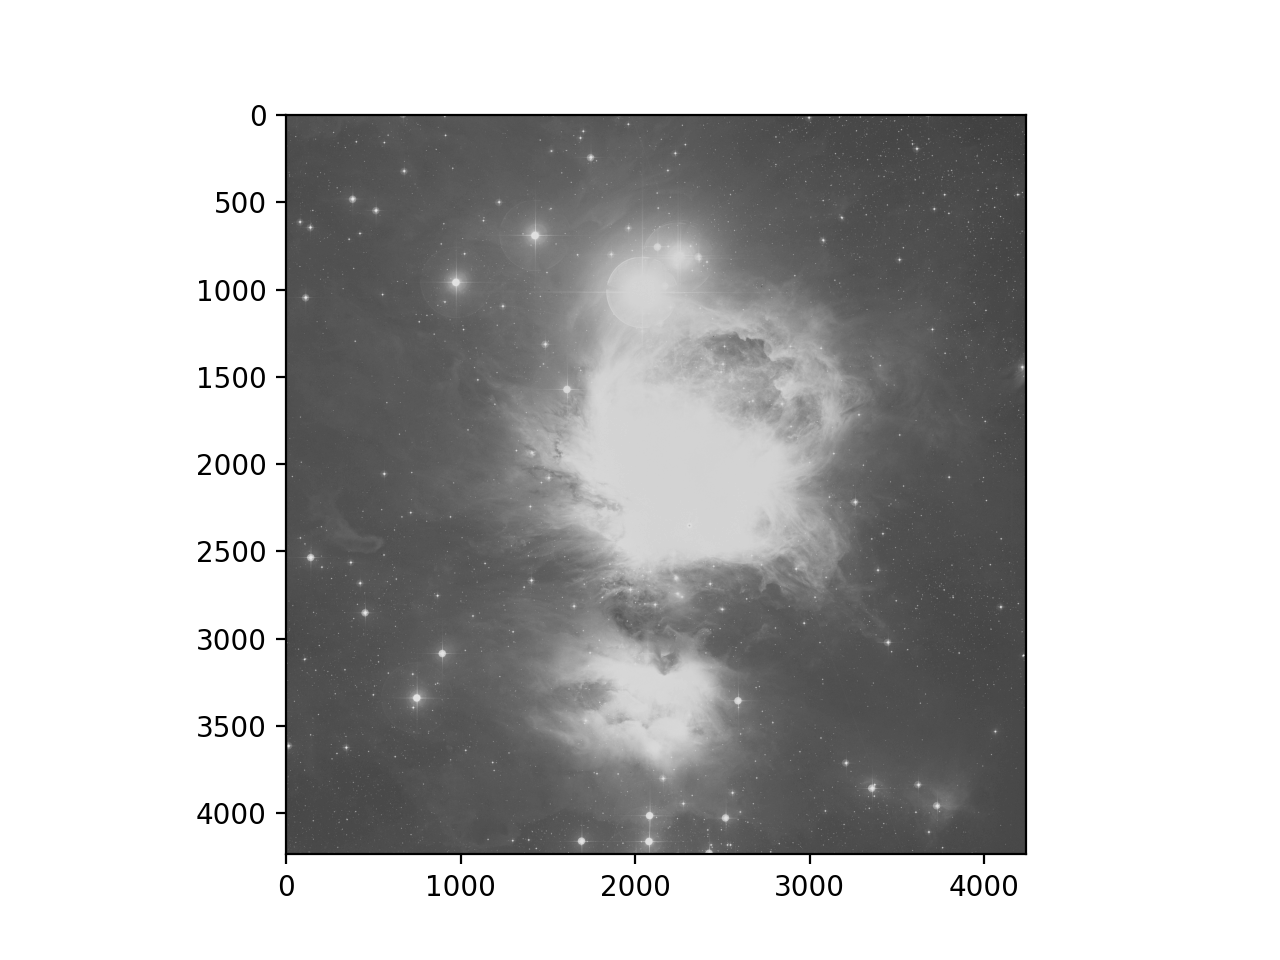

In [5]:
%matplotlib notebook
plt.imshow(i.data, cmap='gray')

## Histogramming

Dask provides wrapper functions for most of the standard numpy functions. Here we demonstrate the histogramming function:

In [6]:
histo, bins = da.histogram(i.data, bins=100, range=[5000,10000])

In [7]:
histo

dask.array<sum-aggregate, shape=(100,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>

Note again that the dask object returned is lazy and needs to be explicitly computed:

In [8]:
%time y = histo.compute()
y

CPU times: user 731 ms, sys: 53.8 ms, total: 785 ms
Wall time: 257 ms


array([  1377,   2522,   3769,   5437,   7716,  11397,  15399,  20484,
        26968,  35922,  47708,  58905,  76511,  92257, 115215, 132896,
       160880, 179440, 203258, 228859, 244658, 262529, 273512, 293051,
       300865, 315913, 320021, 328680, 341137, 339591, 352064, 345225,
       354349, 348053, 348063, 338173, 330378, 329223, 310114, 305468,
       288538, 278636, 259229, 249787, 230959, 219423, 209780, 196804,
       184880, 174576, 167274, 157253, 149248, 140492, 134649, 126824,
       120658, 118108, 109289, 108940,  99999, 100223,  94549,  93683,
        89702,  86999,  85521,  82226,  78747,  76867,  75400,  73999,
        71242,  66999,  65971,  64821,  60638,  61372,  58745,  58023,
        56641,  55929,  53881,  53010,  53293,  52346,  51862,  49653,
        49458,  48088,  47795,  46816,  45348,  45931,  43677,  43031,
        41054,  41970,  39335,  40141])

<IPython.core.display.Javascript object>


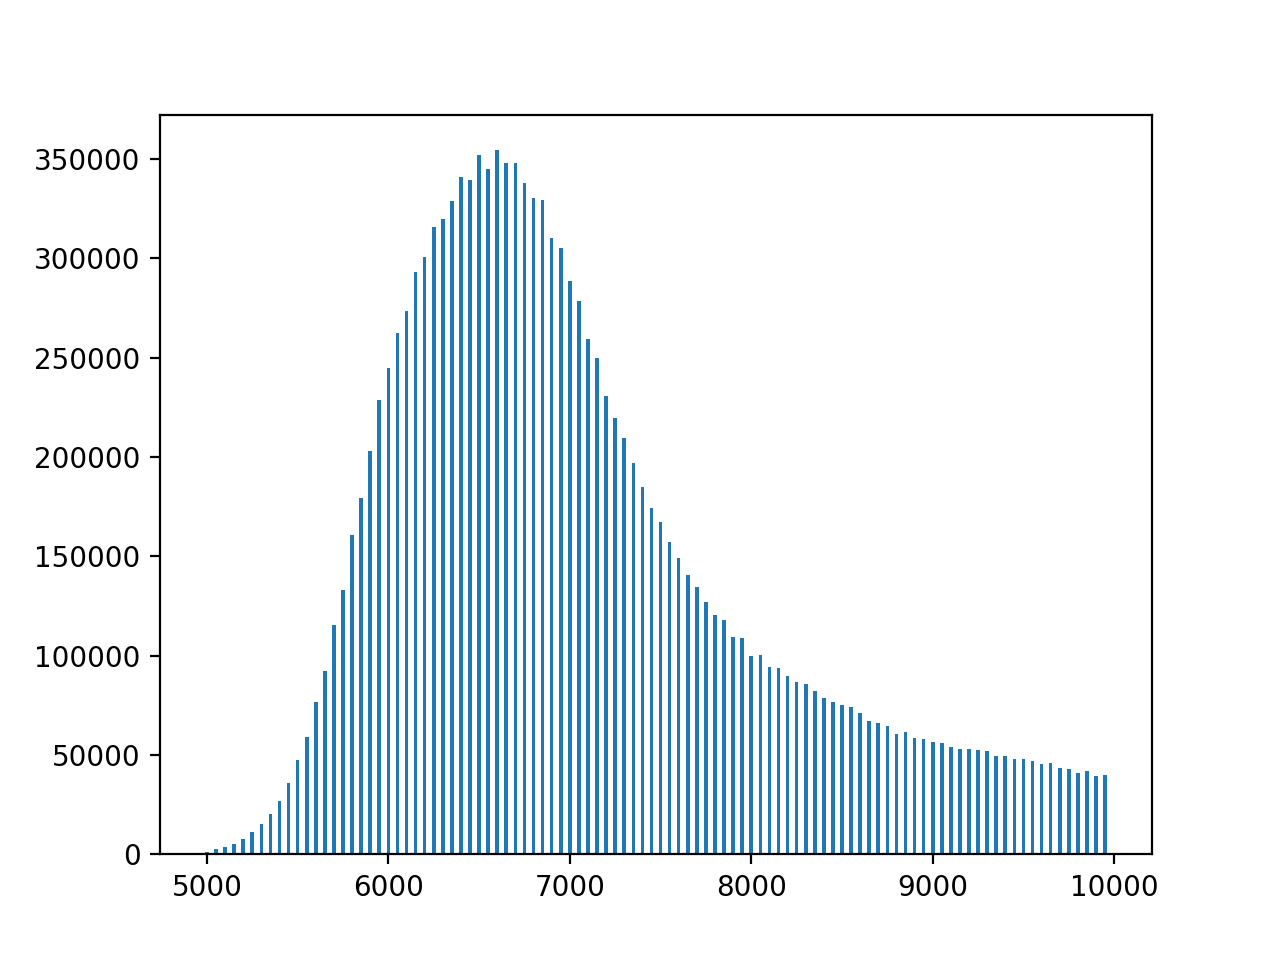

In [9]:
%matplotlib notebook
plt.bar(bins[:100], y, width=20)
plt.show()

## Smoothing

Dask also implements a large set of scipy functionality. Here we demonstrate a similar workflow for gaussian image smoothing:

In [10]:
smooth_array = di.gaussian_filter(i.data, sigma=10)
smooth_array

dask.array<_trim, shape=(4238, 4238), dtype=int16, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [11]:
%time smooth_array.compute()

CPU times: user 1.81 s, sys: 92 ms, total: 1.9 s
Wall time: 591 ms


array([[6542, 6542, 6542, ..., 5370, 5370, 5370],
       [6542, 6542, 6542, ..., 5371, 5371, 5371],
       [6541, 6541, 6541, ..., 5371, 5371, 5372],
       ...,
       [6048, 6048, 6048, ..., 5848, 5848, 5848],
       [6047, 6048, 6048, ..., 5847, 5848, 5848],
       [6047, 6048, 6048, ..., 5847, 5847, 5848]], dtype=int16)

<IPython.core.display.Javascript object>


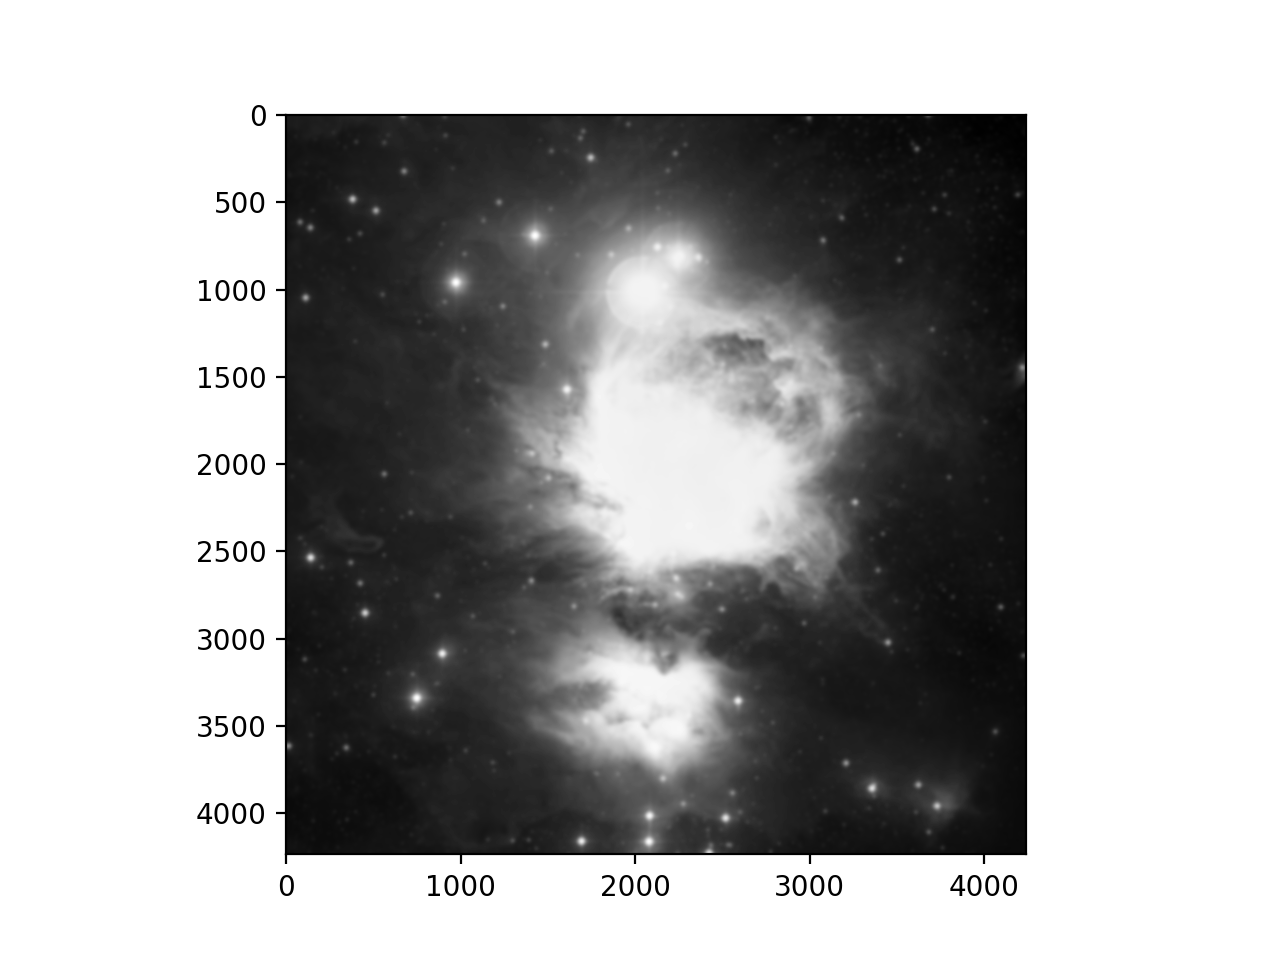

In [12]:
%matplotlib notebook
plt.imshow(smooth_array, cmap='gray')

## dask.distributed

In this simple example, each chunk of the dask array was processed in parallel across the four cores of one machine. However, for larger datasets, dask can be configured to autonomously distribute jobs across large compute clusters over network.